This notebook is for converting pytorch using ONNX

Resources: [ONNX](https://github.com/onnx/tutorials) <br/>
[Torch-onnx](https://pytorch.org/docs/master/onnx.html) <br/>
[Lesson02](https://github.com/SpellOnYou/dlff-note/blob/master/nbs/dl1/lesson2-download.ipynb) <br/>

In [0]:
!pip install tensorflow-gpu
!pip install torch torchvision
!pip install onnx
!git clone https://github.com/onnx/onnx-tensorflow.git

In [0]:
import os
os.chdir('/content/onnx-tensorflow/')

In [0]:
!python setup.py install --user

In [0]:
import tensorflow as tf
import torch
import onnx
from onnx_tf.backend import prepare

/content/onnx-tensorflow/onnx_tf/common/__init__.py:89: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)


-----train the model

In [0]:
from fastai.vision import *

In [0]:
folders=['VW GOLF', 'VW TIGUAN', 'VW POLO','VW PASSAT','MERCEDES C-CLASS','SKODA OCTAVIA','AUDI A4','AUDI S4','AUDI RS4','MINI MINI',
        'FORD FOCUS','OPEL CORSA','FORD FIESTA','OPEL ASTRA']

for fld in folders:
    path = Path('/content/data/car')
    dest = path/fld
    dest.mkdir(parents=True, exist_ok=True)
    file = fld+'.csv'
    download_images(path/file, dest, max_pics=200)

In [0]:
classes = folders

In [5]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=2700)

VW GOLF


VW TIGUAN


VW POLO


VW PASSAT


MERCEDES C-CLASS


SKODA OCTAVIA


AUDI A4


AUDI S4


AUDI RS4


MINI MINI


FORD FOCUS


OPEL CORSA


FORD FIESTA


OPEL ASTRA


What does meaning of `vision.data size params?`

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=330, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['AUDI A4',
 'AUDI RS4',
 'AUDI S4',
 'FORD FIESTA',
 'FORD FOCUS',
 'MERCEDES C-CLASS',
 'MINI MINI',
 'OPEL ASTRA',
 'OPEL CORSA',
 'SKODA OCTAVIA',
 'VW GOLF',
 'VW PASSAT',
 'VW POLO',
 'VW TIGUAN']

In [0]:
data.c, len(data.train_ds), len(data.valid_ds)

(14, 1728, 432)

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, wd=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Learn for frozen layers

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


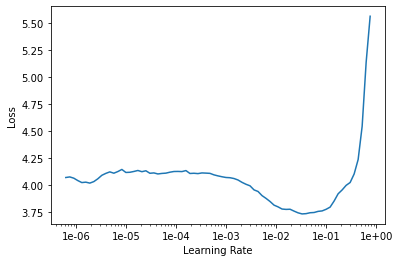

In [8]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 5e-03

In [11]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.525578,1.992119,0.627315,00:17
1,1.619701,2.126146,0.662037,00:17
2,1.576510,2.039678,0.627315,00:17
3,1.442980,1.979206,0.599537,00:17
4,1.332447,1.965237,0.592593,00:17


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


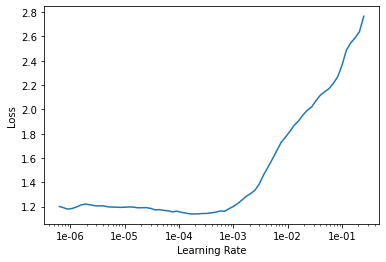

In [12]:
learn.save('stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(7, max_lr=slice(5e-05,lr/10))

epoch,train_loss,valid_loss,error_rate,time
0,1.189466,1.951638,0.576389,00:17
1,1.139849,2.031852,0.611111,00:17
2,1.033634,2.049625,0.615741,00:17
3,0.896094,2.003143,0.567130,00:17
4,0.715108,1.970834,0.569444,00:17
5,0.558780,1.901478,0.557870,00:17
6,0.471356,1.894974,0.546296,00:17


In [0]:
learn.save('stage-2')

In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=330, num_workers=4).normalize(imagenet_stats)

In [0]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=230, train='.', num_workers=16, bs=32, valid_pct=0.2).normalize(imagenet_stats)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


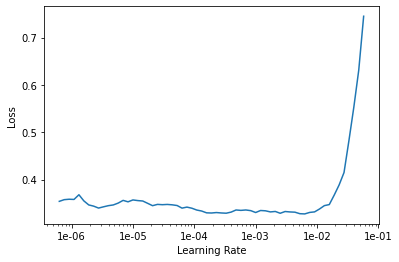

In [26]:
learn.freeze_to(2)
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(8, max_lr=slice(5e-05, 2e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.311569,1.914680,0.550926,00:17
1,0.305155,1.998549,0.518519,00:17
2,0.307317,2.123023,0.520833,00:17
3,0.308709,2.160908,0.523148,00:17
4,0.285030,2.185613,0.532407,00:17
5,0.250936,2.206881,0.520833,00:17
6,0.232816,2.229700,0.518519,00:17
7,0.232820,2.238598,0.518519,00:17


In [0]:
learn.save('stage-3')

About image size
- [Document](https://docs.fast.ai/vision.data.html)
- [forum](https://forums.fast.ai/t/best-way-to-resize-pictures-for-model-training/28307/22)

In [0]:
learn.load('stage-3')

In [0]:
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
free = gpu_mem_get_free_no_cache()
free

14617

In [0]:
src=ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=16,
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
#attribute error
# data = (src.transform(get_transforms()
#         # , size=size
#         ,)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

In [0]:
learn = cnn_learner(src, models.resnet34, metrics=error_rate)

In [0]:
learn.load('stage-3')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.91E-05


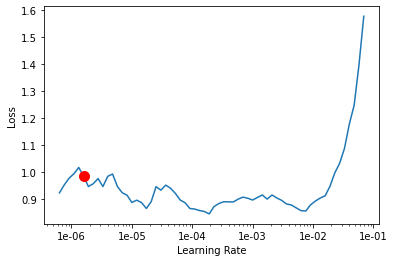

In [0]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr =1.58E-06
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.915594,0.390584,0.100467,00:19
1,0.876138,0.402183,0.102804,00:19
2,0.940522,0.403678,0.102804,00:19
3,0.907052,0.400356,0.102804,00:19
4,0.873639,0.397092,0.100467,00:19
5,0.863783,0.397848,0.098131,00:19
6,0.874066,0.391291,0.102804,00:19
7,0.882566,0.392054,0.095794,00:19
8,0.928212,0.403511,0.107477,00:19
9,0.830263,0.397166,0.100467,00:19


In [0]:
learn.save('stage-1-big', return_path=True)

PosixPath('data/cars/models/stage-1-big.pth')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.25E-06


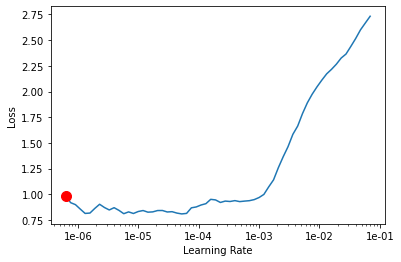

In [0]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lrs = slice(6.31E-07,lr/10)
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,error_rate,time
0,0.895550,0.393539,0.100467,00:20
1,0.877043,0.411422,0.105140,00:20
2,0.933294,0.406603,0.102804,00:20
3,0.920779,0.392009,0.107477,00:21
4,0.844603,0.398215,0.098131,00:20
5,0.925449,0.400156,0.100467,00:21
6,0.906099,0.401248,0.102804,00:20
7,0.839381,0.388991,0.100467,00:20
8,0.888014,0.398889,0.102804,00:19
9,0.894234,0.394684,0.102804,00:19


In [0]:
# show for site

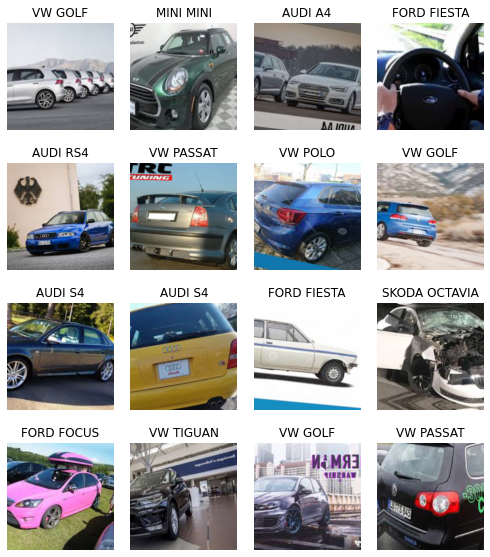

In [0]:
src.show_batch(rows=5, figsize=(7,8))

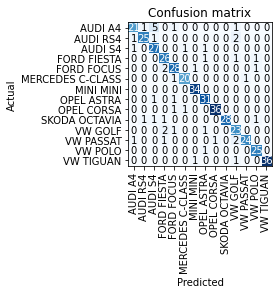

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

-----------new era

In [0]:
learn.save('stage-4')

In [0]:
data2=ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=16,
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(src, models.resnet34, metrics=error_rate)
learn.load('stage-4')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.10E-07


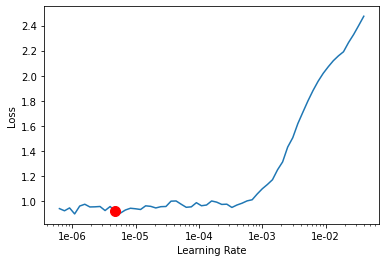

In [0]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr =4.79E-06
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.871798,0.392361,0.105140,00:20
1,0.879623,0.403271,0.095794,00:20
2,0.922442,0.390996,0.093458,00:20
3,0.900683,0.396264,0.100467,00:20
4,0.899885,0.389998,0.107477,00:20
5,0.887227,0.395308,0.098131,00:20
6,0.816731,0.386561,0.102804,00:20
7,0.835803,0.397373,0.098131,00:20
8,0.899065,0.388938,0.102804,00:20
9,0.861731,0.399464,0.107477,00:20


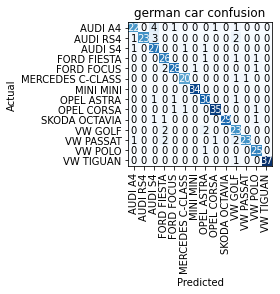

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='german car confusion')

In [0]:
learn.export()